## SetUp

In [44]:
import boto3
from langchain_aws import ChatBedrockConverse
from langchain_aws import AmazonKnowledgeBasesRetriever

In [45]:
# Set up Bedrock LLM
bedrock_client = boto3.client("bedrock-runtime", region_name="us-west-1")
model_id = "us.amazon.nova-lite-v1:0"
provider_id = "amazon"

llm = ChatBedrockConverse(
    model=model_id,
    provider=provider_id,
    temperature=0.5,
    max_tokens=None,
    client=bedrock_client
)

# TODO: Set your Bedrock Knowledge Base ID here
knowledge_base_id = ""  # <-- FILL THIS IN

retriever = AmazonKnowledgeBasesRetriever(
    knowledge_base_id=knowledge_base_id,
    region_name="us-west-1",
    retrieval_config={"vectorSearchConfiguration": {"numberOfResults": 4}},
)

In [46]:
from langchain_core.tools import tool

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    docs = retriever.invoke(query)
    serialized = "\n\n".join(
        (f"Source: {getattr(doc, 'metadata', {})}\nContent: {getattr(doc, 'page_content', str(doc))}")
        for doc in docs
    )
    return serialized, docs

In [47]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import MessagesState


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [48]:
from langgraph.graph import END
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph

memory = MemorySaver()

graph_builder = StateGraph(MessagesState)
graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile(checkpointer=memory)
# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

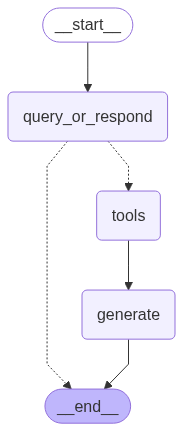

In [49]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [50]:
input_message = "when should you build an agent?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

when should you build an agent?


ValidationException: An error occurred (ValidationException) when calling the Converse operation: The provided model identifier is invalid.

In [ ]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()